In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from umap import UMAP


from sklearn.preprocessing import normalize

In [3]:
df = pd.read_csv('./datasets/stars.csv')

<Axes: >

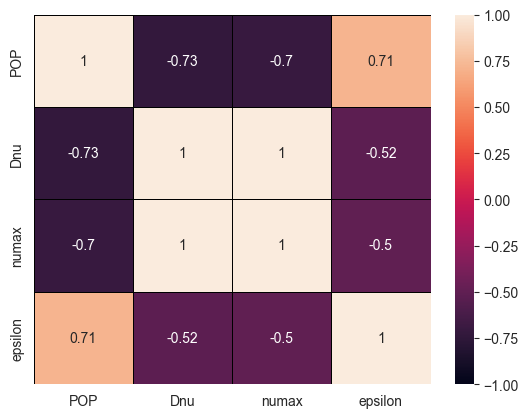

In [4]:
sns.heatmap(df.corr(), annot=True, linewidths=0.5, linecolor='black', vmin=-1, vmax=1)

POP:  
0 - RGB (Red Gaint Branch)  
1 - HeB (Helium Burning)  
DNU - среднее частотное разделение  
numax - частота максимальной мощности колебаний  
epsilon - расположение  

In [5]:
def print_clusters(y, X, cols):
    _, ax = plt.subplots(len(cols), len(cols), figsize=(20, 20))

    for i, col_f in enumerate(cols):
        for j, col_s in enumerate(cols):
            rgb_idx = np.where(y==0)
            heb_idx = np.where(y==1)

            ax[i][j].scatter(X[heb_idx,i], X[heb_idx,j], label='heb', color='b')
            ax[i][j].scatter(X[rgb_idx,i], X[rgb_idx,j], label='rgb', color='r')

            ax[i][j].set_title(f'{col_f} - {col_s}')
            ax[i][j].set_xlabel(col_f)
            ax[i][j].set_ylabel(col_s)

            ax[i][j].legend()

    plt.show()

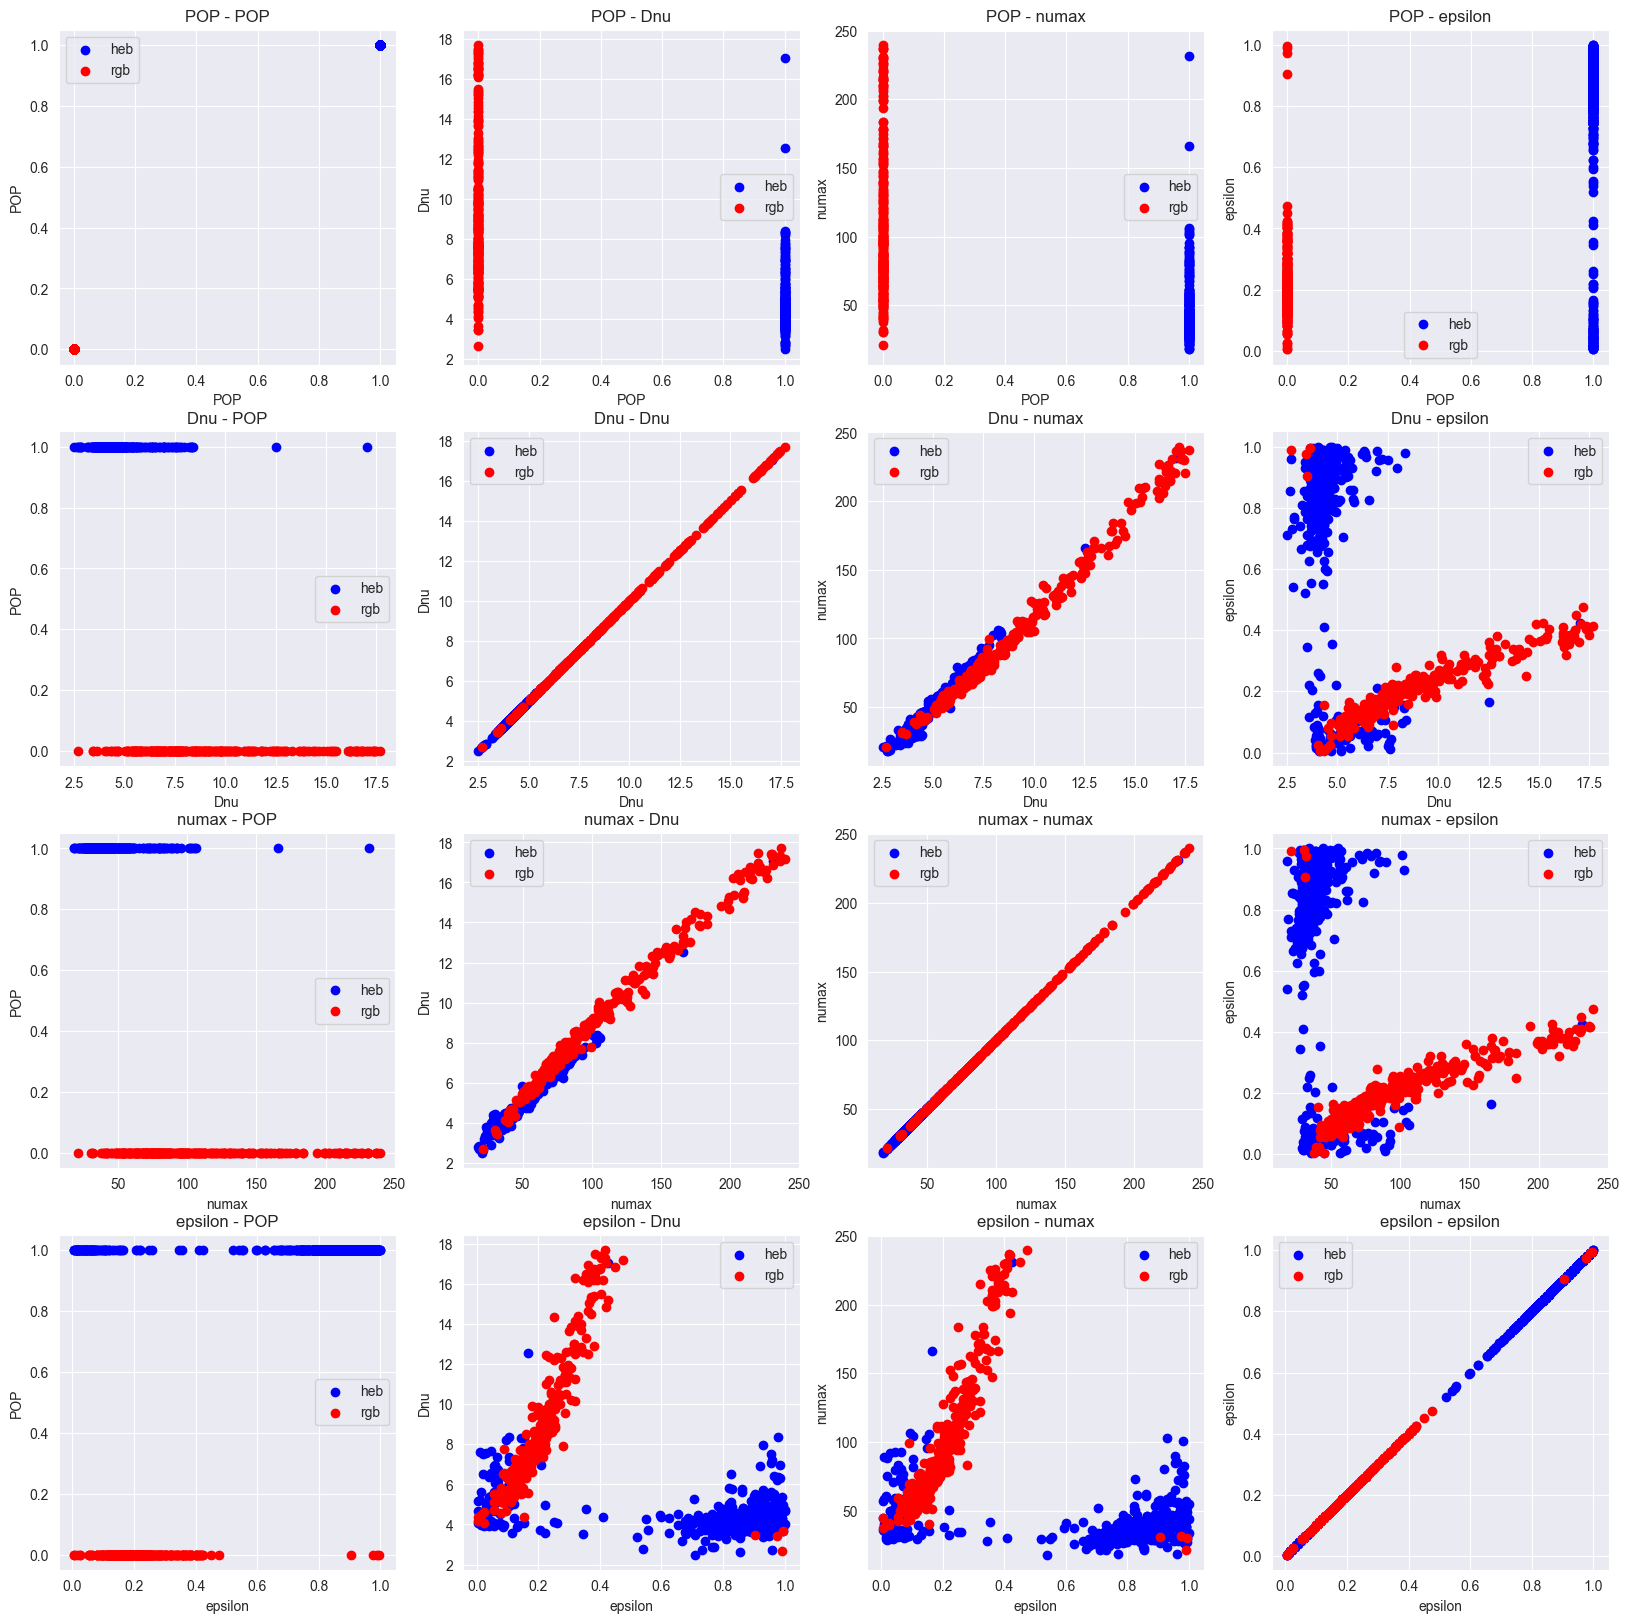

In [6]:
print_clusters(df['POP'], df.to_numpy(), df.columns)

In [7]:
labels = df['POP']
x = df[['Dnu', 'numax', 'epsilon']]

In [8]:
x_norm = normalize(x)

In [9]:
x.shape, x_norm.shape

((1001, 3), (1001, 3))

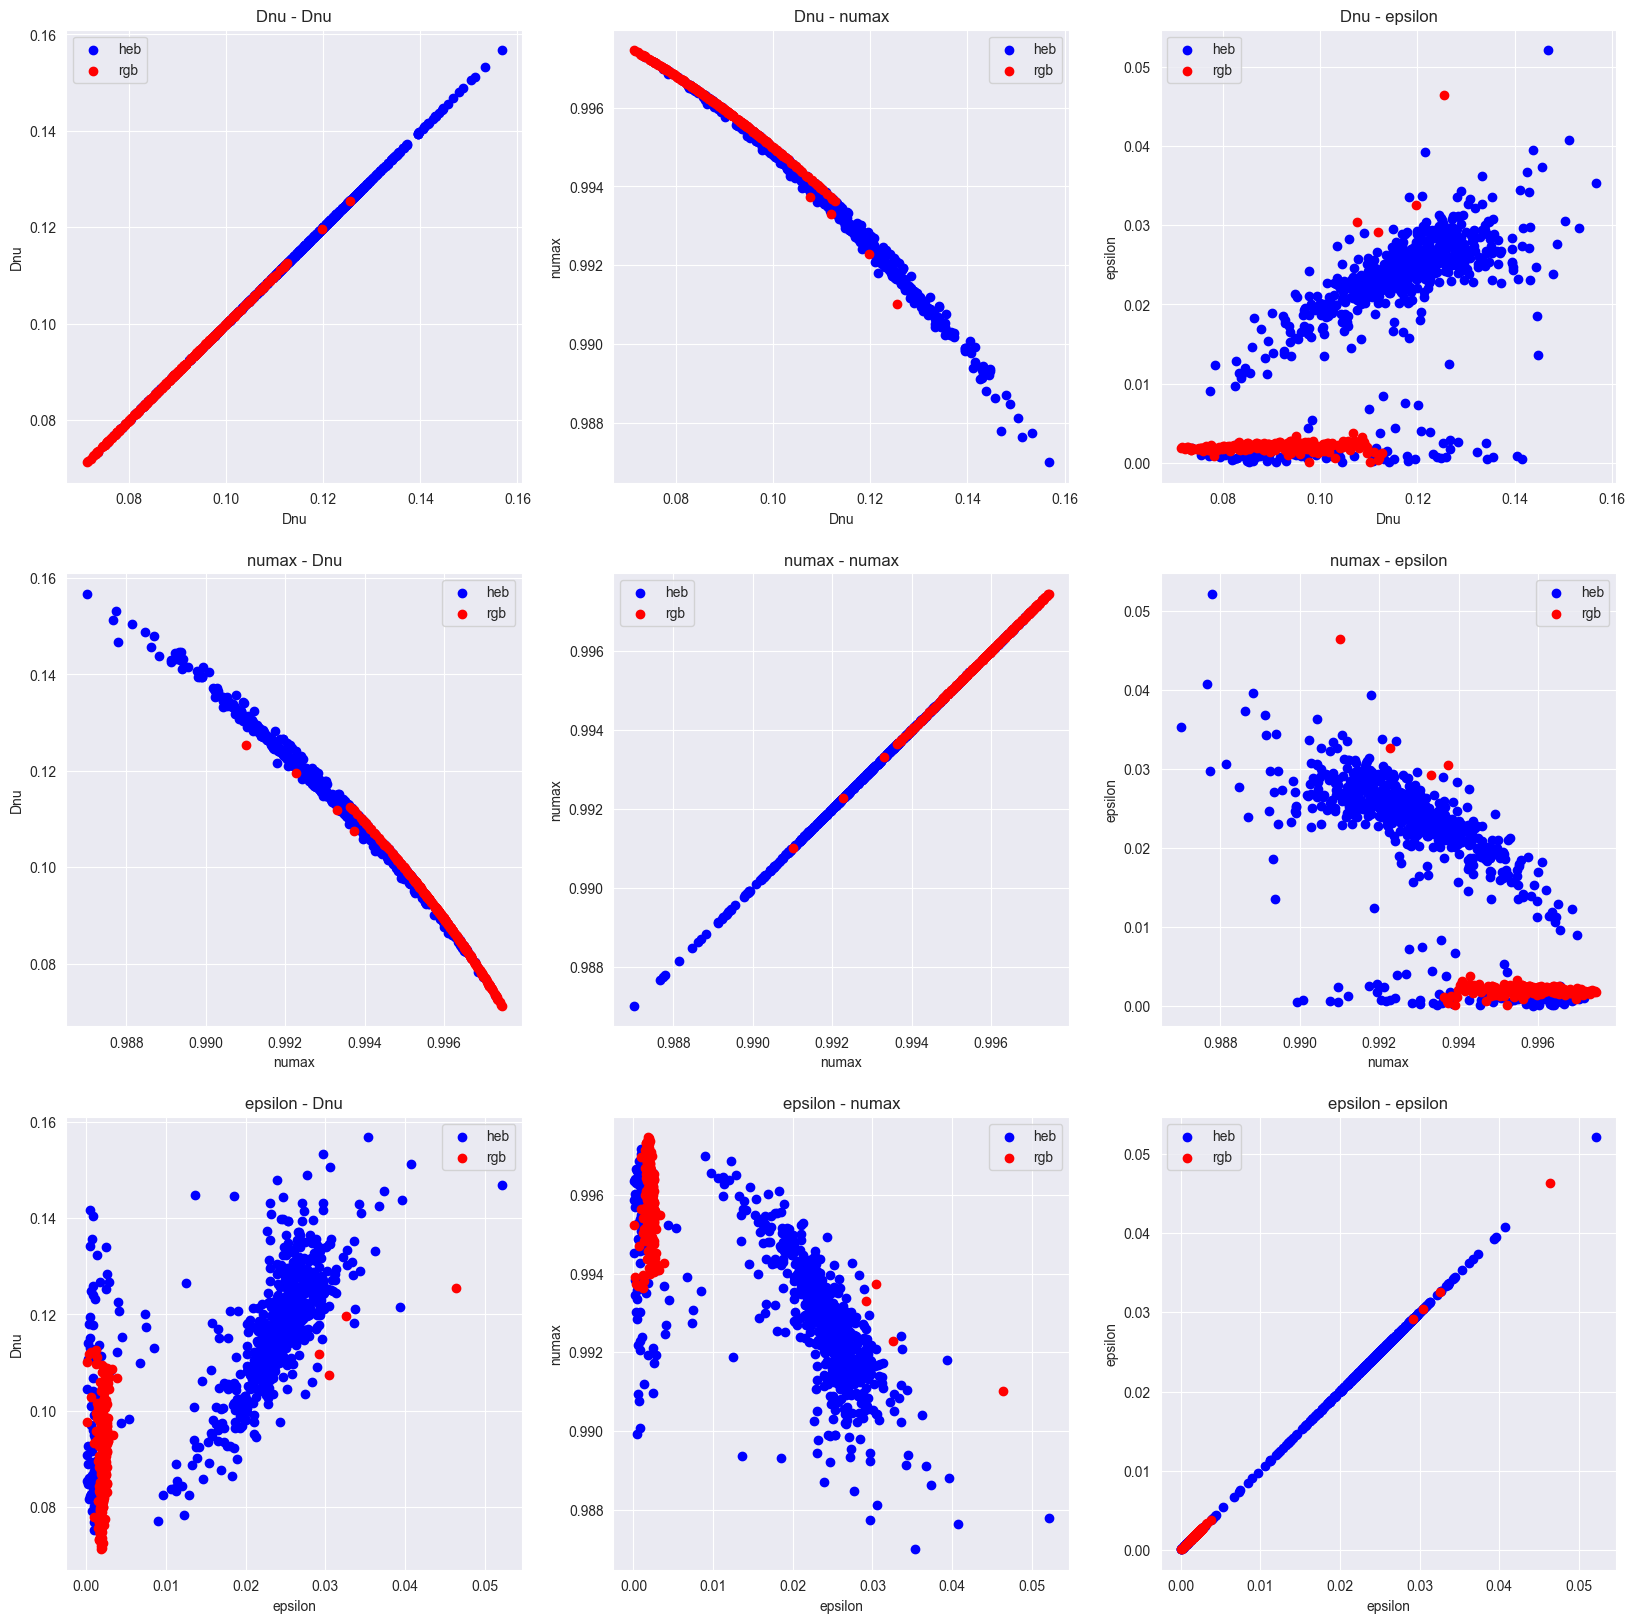

In [10]:
print_clusters(labels, x_norm, ['Dnu', 'numax', 'epsilon'])

In [11]:
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay

In [12]:
train_x, test_x, train_y, test_y = train_test_split(x, labels, test_size=0.2, random_state=42)

In [13]:
x_umap_train = UMAP(n_neighbors=8, random_state=42).fit_transform(train_x)
x_umap_test = UMAP(n_neighbors=8, random_state=42).fit_transform(test_x)

In [14]:
one_model = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(), max_iter=1000)
one_model.fit(train_x, train_y)
one_pred_y = one_model.predict(test_x)
one_error = mean_squared_error(test_y, one_pred_y)
print(f'Error {round(one_error,4)}')

Error 0.0498


In [15]:
multi_model = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(100,),max_iter=1000)
multi_model.fit(train_x, train_y)
multi_pred_y = multi_model.predict(test_x)
multi_error = mean_squared_error(test_y, multi_pred_y)
print(f'Error {round(multi_error,4)}')

Error 0.0448


Text(0.5, 1.0, 'Multi Perceptron Predicted labels. Error: 0.0448')

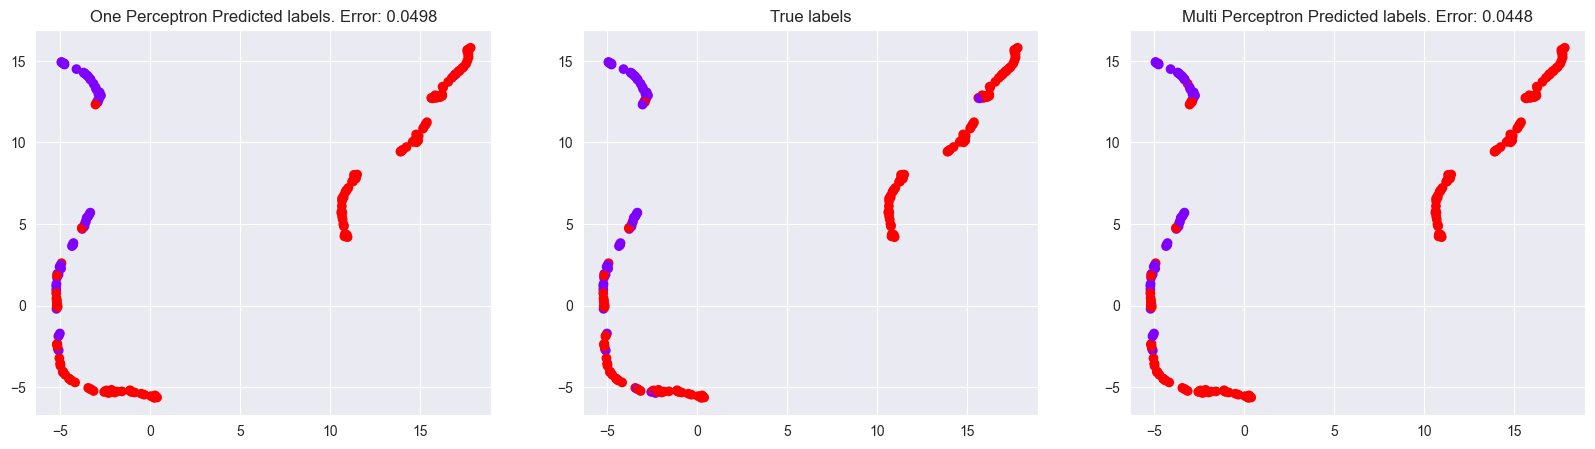

In [16]:
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.scatter(x_umap_test[:,0], x_umap_test[:,1], c=one_pred_y, cmap='rainbow')
plt.title(f'One Perceptron Predicted labels. Error: {round(one_error, 4)}')

plt.subplot(132)
plt.scatter(x_umap_test[:,0], x_umap_test[:,1], c=test_y, cmap='rainbow')
plt.title('True labels')

plt.subplot(133)
plt.scatter(x_umap_test[:,0], x_umap_test[:,1], c=multi_pred_y, cmap='rainbow')
plt.title(f'Multi Perceptron Predicted labels. Error: {round(multi_error, 4)}')

Perceptron confusion matrix. Scores: F1, accuracy

In [17]:
def print_confusion_matrix(test, preds, names, errors):
    print('\t\t\t\t\t\t\tError\t\t\tAccuracy\t\tPrecision\t\tRecall\t\tF1-score')

    for pred, name, error in zip(preds, names, errors):
        cm = confusion_matrix(test, pred)
        tn, fp, fn, tp = cm.ravel()
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)

        fig, _ = plt.subplots(nrows=1, figsize=(5,5))
        ax = plt.subplot(1, 1, 1)
        ax.grid(False)
        disp.plot(cmap='Purples', ax=ax)

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        my_f1 = 2 * precision * recall / (precision + recall)
        accuracy = (tp + tn) / (tp + tn + fp + fn)

        print(
            f'{name}'
            f'{round(error, 3)}\t\t\t'
            f'{round(accuracy, 3)}\t\t\t'
            f'{round(precision, 3)}\t\t\t'
            f'{round(recall, 3)}\t\t'
            f'{round(my_f1, 3)}'
        )

In [18]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()
log_model.fit(train_x, train_y)
log_pred_y = log_model.predict(test_x)
log_error = mean_squared_error(test_y, log_pred_y)

In [19]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier()
tree_clf.fit(train_x, train_y)
tree_pred_y = tree_clf.predict(test_x)
tree_error = mean_squared_error(test_y, tree_pred_y)

							Error			Accuracy		Precision		Recall		F1-score
Perceptron					0.05			0.95			0.966			0.966		0.966
Multi Perceptron			0.045			0.955			0.959			0.979		0.969
Logistic Regression			0.045			0.955			0.966			0.972		0.969
Decision Tree Classifier	0.04			0.96			0.972			0.972		0.972


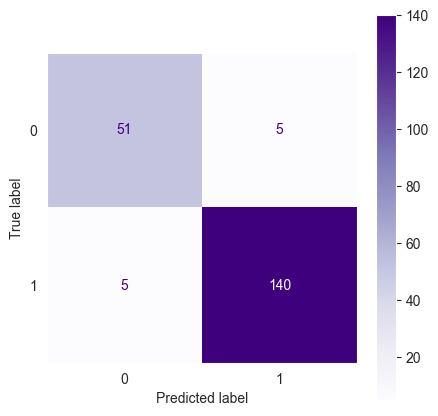

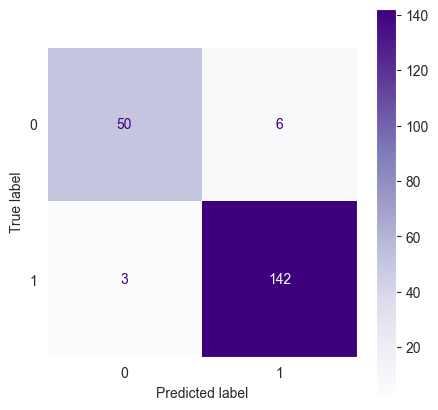

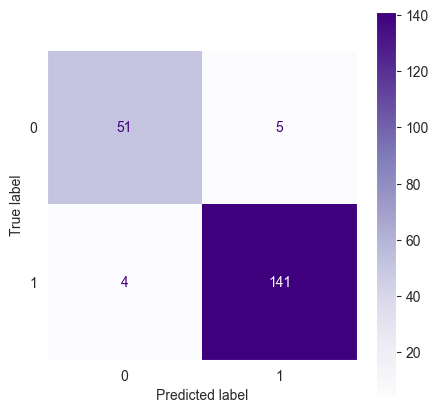

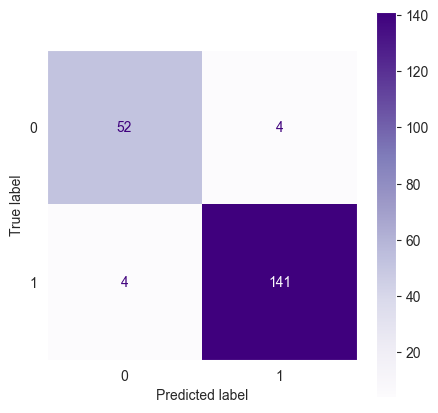

In [20]:
print_confusion_matrix(
    test_y,
    (one_pred_y,multi_pred_y,log_pred_y,tree_pred_y),
    ('Perceptron\t\t\t\t\t','Multi Perceptron\t\t\t','Logistic Regression\t\t\t','Decision Tree Classifier\t'),
    (one_error,multi_error,log_error,tree_error)
)